### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [95]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [96]:
var_name = 'Crc'
sat_var = 2

In [97]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [98]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,Crc
Epoch_Time_of_Clock,
2017-11-02 00:00:00,282.34585029499999109248
2017-11-02 01:00:00,284.07928580200001533740
2017-11-02 02:00:00,286.24442521299999953044
2017-11-02 03:00:00,288.81768948799998497634
2017-11-02 04:00:00,291.75098147900001777089


In [99]:
test = df.iloc[265:408,:]

In [100]:

df.head(7)

,Crc
Epoch_Time_of_Clock,
2017-11-02 00:00:00,282.34585029499999109248
2017-11-02 01:00:00,284.07928580200001533740
2017-11-02 02:00:00,286.24442521299999953044
2017-11-02 03:00:00,288.81768948799998497634
2017-11-02 04:00:00,291.75098147900001777089
2017-11-02 05:00:00,294.43228751700002021607
2017-11-02 06:00:00,295.75823695899998710956


# Enter number of entries per day

In [101]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [102]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [103]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name ]]
train.head()

,Crc
Epoch_Time_of_Clock,
2017-11-02 00:00:00,282.34585029499999109248
2017-11-02 01:00:00,284.07928580200001533740
2017-11-02 02:00:00,286.24442521299999953044
2017-11-02 03:00:00,288.81768948799998497634
2017-11-02 04:00:00,291.75098147900001777089


In [104]:

train.tail(6)

,Crc
Epoch_Time_of_Clock,
2017-11-06 18:00:00,186.81115933799998174436
2017-11-06 19:00:00,186.35334683199999972203
2017-11-06 20:00:00,185.05081560299998955088
2017-11-06 21:00:00,182.84306859000000144988
2017-11-06 22:00:00,179.66960873200000037286
2017-11-06 23:00:00,175.46993896700004711420


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [105]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [106]:
import pickle
file_x = open(var_name+'_X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'_y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [107]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [108]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.89221813742056055307  0.91893476573480425973   
2017-11-03 00:00:00  0.91893476573480425973  0.95461468095104007325   
2017-11-03 01:00:00  0.95461468095104007325  0.99855836350331406148   
2017-11-03 02:00:00  0.99855836350331406148  1.04974017106354478024   
2017-11-03 03:00:00  1.04974017106354478024  1.09963364024817633613   
2017-11-03 04:00:00  1.09963364024817633613  1.13286157367701267873   
2017-11-03 05:00:00  1.13286157367701267873  1.14867265758897252326   
2017-11-03 06:00:00  1.14867265758897252326  1.16007282637235786815   
2017-11-03 07:00:00  1.16007282637235786815  1.15323866779492090195   
2017-11-03 08:00:00  1.15323866779492090195  1.08874184278000862847   
2017-11-03 09:00:00  1.08874184278000862847  0.96907291256617944519   
2017-11-03 10:00:00  0.96907291256617944519  0.83883167637617872536   
2017-11-03 11:00:00  0.83883167637617872536  0.72139076776904476063   
2017-11-03 12:00:00  0.72139076776904476063  0.61702114785225292692   
2017-11-03 13:00:00  0.61702114785225292692  0.52498935714683703235   
2017-11-03 14:00:00  0.52498935714683703235  0.44456193617383332750   
2017-11-03 15:00:00  0.44456193617383332750  0.37500542547783211056   
2017-11-03 16:00:00  0.37500542547783211056  0.31558636560342606669   
2017-11-03 17:00:00  0.31558636560342606669  0.26557129707165105792   
2017-11-03 18:00:00  0.26557129707165105792  0.22422676042709788202   
2017-11-03 19:00:00  0.22422676042709788202  0.19081929619080292837   
2017-11-03 20:00:00  0.19081929619080292837  0.16461544490735705026   
2017-11-03 21:00:00  0.16461544490735705026  0.14488174712135165612   
2017-11-03 22:00:00  0.14488174712135165612  0.13088474333026756113   
2017-11-03 23:00:00  0.13088474333026756113  0.12189097410225185891   
2017-11-04 00:00:00  0.12189097410225185891  0.11716697998189604113   
2017-11-04 01:00:00  0.11716697998189604113  0.11597930146667956297   
2017-11-04 02:00:00  0.11597930146667956297  0.11780426378301069035   
2017-11-04 03:00:00  0.11780426378301069035  0.12694323976840579671   
2017-11-04 04:00:00  0.12694323976840579671  0.15189350036778154207   
...                                     ...                     ...   
2017-11-04 18:00:00 -0.36366419892382179091 -0.41242601094510206172   
2017-11-04 19:00:00 -0.41242601094510206172 -0.46215980772713338709   
2017-11-04 20:00:00 -0.46215980772713338709 -0.51381030533973715002   
2017-11-04 21:00:00 -0.51381030533973715002 -0.56832221982918063041   
2017-11-04 22:00:00 -0.56832221982918063041 -0.62664026721817245313   
2017-11-04 23:00:00 -0.62664026721817245313 -0.68970916355298039768   
2017-11-05 00:00:00 -0.68970916355298039768 -0.75847362490342473684   
2017-11-05 01:00:00 -0.75847362490342473684 -0.83387836726865971482   
2017-11-05 02:00:00 -0.83387836726865971482 -0.91587929768689091414   
2017-11-05 03:00:00 -0.91587929768689091414 -0.98168971485667322341   
2017-11-05 04:00:00 -0.98168971485667322341 -0.98753729900276931986   
2017-11-05 05:00:00 -0.98753729900276931986 -0.92907168773837500719   
2017-11-05 06:00:00 -0.92907168773837500719 -0.84213213448519952387   
2017-11-05 07:00:00 -0.84213213448519952387 -0.75922842192815676032   
2017-11-05 08:00:00 -0.75922842192815676032 -0.70676195501112148989   
2017-11-05 09:00:00 -0.70676195501112148989 -0.68740889654508807727   
2017-11-05 10:00:00 -0.68740889654508807727 -0.68082297016024362346   
2017-11-05 11:00:00 -0.68082297016024362346 -0.67671398905439705818   
2017-11-05 12:00:00 -0.67671398905439705818 -0.67586977313137652779   
2017-11-05 13:00:00 -0.67586977313137652779 -0.67955979475332117801   
2017-11-05 14:00:00 -0.67955979475332117801 -0.68905352618814108556   
2017-11-05 15:00:00 -0.6

In [109]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [110]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.37052686796887535081 -1.55052929801516969910   
2017-11-07 01:00:00 -1.55052929801516969910 -1.76040613305934301458   
2017-11-07 02:00:00 -1.76040613305934301458 -1.99972330737476422513   
2017-11-07 03:00:00 -1.99972330737476422513 -2.22528586181856669057   
2017-11-07 04:00:00 -2.22528586181856669057 -2.35230405095496886148   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.76040613305934301458 -1.99972330737476422513   
2017-11-07 01:00:00 -1.99972330737476422513 -2.22528586181856669057   
2017-11-07 02:00:00 -2.22528586181856669057 -2.35230405095496886148   
2017-11-07 03:00:00 -2.35230405095496886148 -2.32094942335267706568   
2017-11-07 04:00:00 -2.32094942335267706568 -2.10242865224219732667   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.22528586181856669057 -2.35230405095496886148   
2017-11-07 01:00:00 -2.35230405095496886148 -2.32094942335267706568   
2017-11-07 02:00:00 -2.32094942335267706568 -2.10242865224219732667   
2017-11-07 03:00:00 -2.10242865224219732667 -1.76605172713521607619   
2017-11-07 04:00:00 -1.76605172713521607619 -1.47328016599051458968   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.32094942335267706568 -2.10242865224219732667   
2017-11-07 01:00:00 -2.10242865224219732667 -1.76605172713521607619   
2017-11-07 02:00:00 -1.76605172713521607619 -1.47328016599051458968   
2017-11-07 03:00:00 -1.47328016599051458968 -1.27971948716939687429   
2017-11-07 04:00:00 -1.27971948716939687429 -1.13216220798613953491   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.76605172713521607619 -1.47328016599051458968   
2017-11-07 01:00:00 -1.47328016599051458968 -1.27971948716939687429   
2017-11-07 02:00:00 -1.27971948716939687429 -1.13216220798613953491   
2017-11-07 03:00:00 -1.13216220798613953491 -1.00154133690497548770   
2017-11-07 04:00:00 -1.00154133690497548770 -0.88771605460420366374   

tensor                        ...                                 X  \
feature                       ...                               Crc   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...           -0.90007205962138869815   
2017-11-07 01:00:00           ...           -0.85971113540441823631   
2017-11-07 02:00:00           ...           -0.83497358059640347516   
2017-11-07 03:00:00           ...           -0.82728449873739173803   
2017-11-07 04:00:00           ...           -0.83806899343809881930   

tensor                                                               \
feature                                                               
time step         

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [111]:
#Image('./images/simple_encoder_decoder.png')

In [112]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [113]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 500

In [114]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [115]:
model.compile(optimizer='RMSprop', loss='mse')

In [116]:


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_3 (Flatten)          (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [117]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [118]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [119]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/500
73/73 [==============================] - 3s 48ms/step - loss: 0.4005 - val_loss: 0.5719
Epoch 2/500
73/73 [==============================] - 0s 5ms/step - loss: 0.1574 - val_loss: 0.9597
Epoch 3/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1409 - val_loss: 0.6961
Epoch 4/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1352 - val_loss: 0.6714
Epoch 5/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1310 - val_loss: 0.6472
Epoch 6/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1272 - val_loss: 0.6390
Epoch 7/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1237 - val_loss: 0.6332
Epoch 8/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1203 - val_loss: 0.6222
Epoch 9/500
73/73 [==============================] - 0s 4ms/step - loss: 0.1172 - val_loss: 0.6061
Epoch 10/500
73/73 [==============================] - 0s 4ms/ste

73/73 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.4701
Epoch 83/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0545 - val_loss: 0.8633
Epoch 84/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.7965
Epoch 85/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 1.1407
Epoch 86/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.9061
Epoch 87/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0506 - val_loss: 0.3957
Epoch 88/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0351 - val_loss: 0.5973
Epoch 89/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.4838
Epoch 90/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.5416
Epoch 91/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.5473
Epoch 92/500


73/73 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.6680
Epoch 164/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.6751
Epoch 165/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.6169
Epoch 166/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0181 - val_loss: 0.4258
Epoch 167/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.4725
Epoch 168/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.4129
Epoch 169/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.5266
Epoch 170/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0172 - val_loss: 0.4588
Epoch 171/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.6509
Epoch 172/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.3401
Epoc

73/73 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.4688
Epoch 245/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.6972
Epoch 246/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.6599
Epoch 247/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.4627
Epoch 248/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.3871
Epoch 249/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.5736
Epoch 250/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.4296
Epoch 251/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.6369
Epoch 252/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.3613
Epoch 253/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.6242
Epoc

73/73 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.4225
Epoch 326/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.5180
Epoch 327/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.5635
Epoch 328/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.6972
Epoch 329/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.4422
Epoch 330/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.5271
Epoch 331/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.3783
Epoch 332/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.3553
Epoch 333/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.5212
Epoch 334/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.4259
Epoc

73/73 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.4279
Epoch 407/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.5571
Epoch 408/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.4057
Epoch 409/500
73/73 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.3222
Epoch 410/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.4697
Epoch 411/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.4024
Epoch 412/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.3301
Epoch 413/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.5057
Epoch 414/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.4378
Epoch 415/500
73/73 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.3205
Epoc

73/73 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.4763
Epoch 488/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.4131
Epoch 489/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.3366
Epoch 490/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.4558
Epoch 491/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.4453
Epoch 492/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.3522
Epoch 493/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.4759
Epoch 494/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.3939
Epoch 495/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.3360
Epoch 496/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.4622
Epoc

In [120]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [121]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.40846705086575041399 1.42331307788792793545   
2017-11-14 01:00:00 1.42331307788792793545 1.44268091765729078446   
2017-11-14 02:00:00 1.44268091765729078446 1.46683757443627404982   
2017-11-14 03:00:00 1.46683757443627404982 1.50265926720857412313   
2017-11-14 04:00:00 1.50265926720857412313 1.56260681554847691288   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.44268091765729078446 1.46683757443627404982   
2017-11-14 01:00:00 1.46683757443627404982 1.50265926720857412313   
2017-11-14 02:00:00 1.50265926720857412313 1.56260681554847691288   
2017-11-14 03:00:00 1.56260681554847691288 1.63586226982503246674   
2017-11-14 04:00:00 1.63586226982503246674 1.68871699668476815681   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.50265926720857412313 1.56260681554847691288   
2017-11-14 01:00:00 1.56260681554847691288 1.63586226982503246674   
2017-11-14 02:00:00 1.63586226982503246674 1.68871699668476815681   
2017-11-14 03:00:00 1.68871699668476815681 1.70197292918431730691   
2017-11-14 04:00:00 1.70197292918431730691 1.67257896915826331785   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.63586226982503246674 1.68871699668476815681   
2017-11-14 01:00:00 1.68871699668476815681 1.70197292918431730691   
2017-11-14 02:00:00 1.70197292918431730691 1.67257896915826331785   
2017-11-14 03:00:00 1.67257896915826331785 1.61223058990933387769   
2017-11-14 04:00:00 1.61223058990933387769 1.54613078150948490830   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.70197292918431730691 1.67257896915826331785   
2017-11-14 01:00:00 1.67257896915826331785 1.61223058990933387769   
2017-11-14 02:00:00 1.61223058990933387769 1.54613078150948490830   
2017-11-14 03:00:00 1.54613078150948490830 1.48713124112944194977   
2017-11-14 04:00:00 1.48713124112944194977 1.43512058487221505487   

tensor                       ...                                X  \
feature                      ...                              Crc   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-14 00:00:00          ...           1.51318412736849827738   
2017-11-14 01:00:00          ...           1.48169261561749632250   
2017-11-14 02:00:00          ...           1.45492644594119324708   
2017-11-14 03:00:00          ...           1.43286526536443648006   
2017-11-14 04:00:00          ...           1.41548872098274070019   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

In [61]:
test_inputs.dataframe.head(50)

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.40846705086575041399 1.42331307788792793545   
2017-11-14 01:00:00 1.42331307788792793545 1.44268091765729078446   
2017-11-14 02:00:00 1.44268091765729078446 1.46683757443627404982   
2017-11-14 03:00:00 1.46683757443627404982 1.50265926720857412313   
2017-11-14 04:00:00 1.50265926720857412313 1.56260681554847691288   
2017-11-14 05:00:00 1.56260681554847691288 1.63586226982503246674   
2017-11-14 06:00:00 1.63586226982503246674 1.68871699668476815681   
2017-11-14 07:00:00 1.68871699668476815681 1.70197292918431730691   
2017-11-14 08:00:00 1.70197292918431730691 1.67257896915826331785   
2017-11-14 09:00:00 1.67257896915826331785 1.61223058990933387769   
2017-11-14 10:00:00 1.61223058990933387769 1.54613078150948490830   
2017-11-14 11:00:00 1.54613078150948490830 1.48713124112944194977   
2017-11-14 12:00:00 1.48713124112944194977 1.43512058487221505487   
2017-11-14 13:00:00 1.43512058487221505487 1.38942381667373382470   
2017-11-14 14:00:00 1.38942381667373382470 1.34936594037570589677   
2017-11-14 15:00:00 1.34936594037570589677 1.31427195993761780635   
2017-11-14 16:00:00 1.31427195993761780635 1.28346687920117430437   
2017-11-14 17:00:00 1.28346687920117430437 1.25627570210231054304   
2017-11-14 18:00:00 1.25627570210231054304 1.23202343252984136690   
2017-11-14 19:00:00 1.23202343252984136690 1.21003507437258694956   
2017-11-14 20:00:00 1.21003507437258694956 1.18963563151936768669   
2017-11-14 21:00:00 1.18963563151936768669 1.17015010788255535701   
2017-11-14 22:00:00 1.17015010788255535701 1.15090350735096924595   
2017-11-14 23:00:00 1.15090350735096924595 1.13122083383698690540   
2017-11-15 00:00:00 1.13122083383698690540 1.11042709120586802207   
2017-11-15 01:00:00 1.11042709120586802207 1.08784728339354552773   
2017-11-15 02:00:00 1.08784728339354552773 1.06370108215332881407   
2017-11-15 03:00:00 1.06370108215332881407 1.05878552080499099830   
2017-11-15 04:00:00 1.05878552080499099830 1.11225333198464548801   
2017-11-15 05:00:00 1.11225333198464548801 1.21305368670170876655   
2017-11-15 06:00:00 1.21305368670170876655 1.30030731974775992654   
2017-11-15 07:00:00 1.30030731974775992654 1.34011854918714523599   
2017-11-15 08:00:00 1.34011854918714523599 1.32850512027907319279   
2017-11-15 09:00:00 1.32850512027907319279 1.27904274702008513565   
2017-11-15 10:00:00 1.27904274702008513565 1.22093718947932905472   
2017-11-15 11:00:00 1.22093718947932905472 1.16896540809626570123   
2017-11-15 12:00:00 1.16896540809626570123 1.12276738212645987858   
2017-11-15 13:00:00 1.12276738212645987858 1.08132496124566213069   
2017-11-15 14:00:00 1.08132496124566213069 1.04361999508250513635   
2017-11-15 15:00:00 1.04361999508250513635 1.00863433333629326505   
2017-11-15 16:00:00 1.00863433333629326505 0.97534982563566197111   
2017-11-15 17:00:00 0.97534982563566197111 0.94274832165635624737   
2017-11-15 18:00:00 0.94274832165635624737 0.90981167105057070277   
2017-11-15 19:00:00 0.90981167105057070277 0.87552172347049550538   
2017-11-15 20:00:00 0.87552172347049550538 0.83886032859187742439   
2017-11-15 21:00:00 0.83886032859187742439 0.79880933606690807114   
2017-11-15 22:00:00 0.79880933606690807114 0.75435059554777850188   
2017-11-15 23:00:00 0.75435059554777850188 0.70446595671023592988   
2017-11-16 00:00:00 0.70446595671023592988 0.64813726920647130036   
2017-11-16 01:00:00 0.64813726920647130036 0.58434638266512017868   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                               

In [62]:
test_inputs.dataframe.shape

(96, 48)

In [63]:
predictions = model.predict(test_inputs['X'])

In [64]:
predictions

array([[ 1.0444053 ,  1.0704128 ,  0.9639672 , ...,  0.32756433,
         0.31427658,  0.30804256],
       [ 1.0815178 ,  1.1111289 ,  1.0069687 , ...,  0.31847617,
         0.31401116,  0.31671724],
       [ 1.1118871 ,  1.1420203 ,  1.0362047 , ...,  0.3137412 ,
         0.31830415,  0.3287495 ],
       ...,
       [-0.11113282, -0.16009994, -0.21645088, ..., -0.63492393,
        -0.61208606, -0.59690785],
       [-0.14578764, -0.19524711, -0.25082725, ..., -0.63401616,
        -0.6174116 , -0.60790956],
       [-0.18762535, -0.23800327, -0.29383302, ..., -0.63403356,
        -0.6278486 , -0.6255568 ]], dtype=float32)

In [65]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h               prediction                   actual
0 2017-11-14 00:00:00  t+1 266.26625110012292907413 281.72103208800001539203
1 2017-11-14 01:00:00  t+1 267.84171248236293649825 282.35126067300001295735
2 2017-11-14 02:00:00  t+1 269.13091864156126575836 283.17344469799996886650
3 2017-11-14 03:00:00  t+1 270.09285379822574668651 284.19891875900003697097
4 2017-11-14 04:00:00  t+1 270.69881955809358942133 285.71958517799998844566
               timestamp     h               prediction  \
2299 2017-11-17 19:00:00  t+24 197.55129359344894623973   
2300 2017-11-17 20:00:00  t+24 197.05783910137247971761   
2301 2017-11-17 21:00:00  t+24 196.59087660258924756818   
2302 2017-11-17 22:00:00  t+24 196.12384325606842594425   
2303 2017-11-17 23:00:00  t+24 195.37469927915293510523   

                       actual  
2299 206.11884402499998714120  
2300 204.99073855000000321525  
2301 203.44301492900001449016  
2302 201.45850220700000932084  
2303 199.02002942900000

In [66]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.03408581025347625498
t+10   0.08076427397384798590
t+11   0.08294628634095575770
t+12   0.08541626037281178918
t+13   0.08759056829563477420
t+14   0.08923614435702846570
t+15   0.09020489066300009517
t+16   0.09040247356932522294
t+17   0.08978060270056870129
t+18   0.08835087154890695904
t+19   0.08633278523474058330
t+2    0.03686029774244622276
t+20   0.08422004919338739459
t+21   0.08234469518742724981
t+22   0.08009104125967977938
t+23   0.07817371142078040347
t+24   0.07562407991534447760
t+3    0.04827697960736493377
t+4    0.05628950624301724132
t+5    0.06307640499574164450
t+6    0.06883877955872494403
t+7    0.07337757550319914945
t+8    0.07656274371921249766
t+9    0.07876951379731216007
Name: APE, dtype: float64

In [67]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

19.131261170423286

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

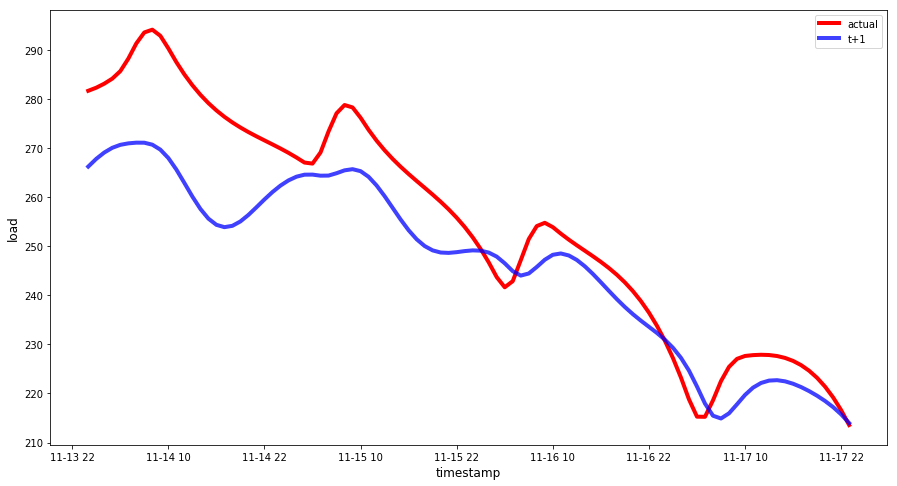

In [122]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
#ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
#ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [69]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [70]:
new_df = pd.DataFrame()

In [71]:
columns = Paras[var_name] 

In [72]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [73]:
new_df = new_df.dropna( how = 'any')

In [74]:
new_df

,Crc
Epoch_Time_of_Clock,
2017-11-21 00:00:00,178.53213341299999683542
2017-11-21 01:00:00,176.59860644700000875673
2017-11-21 02:00:00,174.27104345200001489502
2017-11-21 03:00:00,171.54504149999999640386
2017-11-21 04:00:00,168.45591684999999415595
2017-11-21 05:00:00,165.95252708799998231370
2017-11-21 06:00:00,165.79126688400000944057
2017-11-21 07:00:00,167.33015256400000225767
2017-11-21 08:00:00,167.61387889600001699364


In [75]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [76]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [77]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [78]:
new_df.index= date

In [79]:
new_df.columns

Index(['Crc'], dtype='object')

In [80]:
print(new_df)
print(new_df.columns)

                                         Crc
Epoch_Time_of_Clock                         
2017-11-22 00:00:00 178.53213341299999683542
2017-11-22 01:00:00 176.59860644700000875673
2017-11-22 02:00:00 174.27104345200001489502
2017-11-22 03:00:00 171.54504149999999640386
2017-11-22 04:00:00 168.45591684999999415595
2017-11-22 05:00:00 165.95252708799998231370
2017-11-22 06:00:00 165.79126688400000944057
2017-11-22 07:00:00 167.33015256400000225767
2017-11-22 08:00:00 167.61387889600001699364
2017-11-22 09:00:00 166.45098374799999874085
2017-11-22 10:00:00 166.43192846899998471599
2017-11-22 11:00:00 168.24970150600000806662
2017-11-22 12:00:00 170.60437978900000643989
2017-11-22 13:00:00 172.78287564799998676790
2017-11-22 14:00:00 174.74686067599998295918
2017-11-22 15:00:00 176.48734382300000333998
2017-11-22 16:00:00 177.99533404099997824233
2017-11-22 17:00:00 179.26184028200000852848
2017-11-22 18:00:00 180.27787149700000668417
2017-11-22 19:00:00 181.03443663699999888195
2017-11-22

In [81]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Crc
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -1.02230999508148312493
2017-11-22 01:00:00 -1.06785726835431482584
2017-11-22 02:00:00 -1.12268668095480905755
2017-11-22 03:00:00 -1.18690195078726423716
2017-11-22 04:00:00 -1.25967114774264388188


In [82]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                                 Crc                           
time step                              t-23                    t-22   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -1.02230999508148312493 -1.06785726835431482584   

tensor                                                               \
feature                                                               
time step                              t-21                    t-20   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -1.12268668095480905755 -1.18690195078726423716   

tensor                                                               \
feature                                                               
time step                              t-19                    t-18   
Epoch_Time_of_Clock                                                   
2017

In [83]:
predictions = model.predict(inputs['X'])

In [84]:
predictions

array([[-1.0993268 , -1.1320528 , -1.2253407 , -1.2968932 , -1.378943  ,
        -1.4496332 , -1.4845475 , -1.4649638 , -1.3917907 , -1.2857014 ,
        -1.1745294 , -1.0745488 , -0.9884229 , -0.9158329 , -0.85804677,
        -0.81793404, -0.7985681 , -0.80144775, -0.82493114, -0.8633785 ,
        -0.9077221 , -0.94985723, -0.9896022 , -1.03759   ]],
      dtype=float32)

In [85]:
print(predictions.shape)


(1, 24)


In [86]:
results = predictions[-1, :]

In [87]:
results

array([-1.0993268 , -1.1320528 , -1.2253407 , -1.2968932 , -1.378943  ,
       -1.4496332 , -1.4845475 , -1.4649638 , -1.3917907 , -1.2857014 ,
       -1.1745294 , -1.0745488 , -0.9884229 , -0.9158329 , -0.85804677,
       -0.81793404, -0.7985681 , -0.80144775, -0.82493114, -0.8633785 ,
       -0.9077221 , -0.94985723, -0.9896022 , -1.03759   ], dtype=float32)

In [88]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Crc
0,-1.09932684898376464844
1,-1.13205277919769287109
2,-1.22534072399139404297
3,-1.29689323902130126953
4,-1.37894296646118164062
5,-1.44963324069976806641
6,-1.48454749584197998047
7,-1.46496379375457763672
8,-1.39179074764251708984
9,-1.28570139408111572266


In [89]:
res_df.index = date
res_df

,Crc
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-1.09932684898376464844
2017-11-22 01:00:00,-1.13205277919769287109
2017-11-22 02:00:00,-1.22534072399139404297
2017-11-22 03:00:00,-1.29689323902130126953
2017-11-22 04:00:00,-1.37894296646118164062
2017-11-22 05:00:00,-1.44963324069976806641
2017-11-22 06:00:00,-1.48454749584197998047
2017-11-22 07:00:00,-1.46496379375457763672
2017-11-22 08:00:00,-1.39179074764251708984


In [90]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [93]:
# final generated ouput
res_df['actual'] = Actual
res_df

,Crc,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,175.26269531250000000000,180.61058451400000990361
2017-11-22 01:00:00,173.87344360351562500000,179.62154118400002289491
2017-11-22 02:00:00,169.91328430175781250000,178.31009443900001087968
2017-11-22 03:00:00,166.87580871582031250000,176.66725323099998945509
2017-11-22 04:00:00,163.39271545410156250000,174.72668204599997920923
2017-11-22 05:00:00,160.39183044433593750000,173.50312270900002431517
2017-11-22 06:00:00,158.90969848632812500000,174.86607370099997638135
2017-11-22 07:00:00,159.74104309082031250000,177.82231343400002288035
2017-11-22 08:00:00,162.84730529785156250000,178.62835908799999629082


In [94]:
res_df.to_csv('SA2_Crc.csv')